In [1]:
# Make sure you have APP_DIRECTORY set in your ./.env file!
import sys
from dotenv import load_dotenv, find_dotenv
from sspipe import p
import os
import numpy as np
import pandas as pd
import numpy as np

import seaborn as sns
find_dotenv() | p(load_dotenv)
'APP_DIRECTORY' | p(os.getenv) | p(sys.path.append)


In [2]:
dfs = {
    'aisles': './data/aisles.csv',
    'orders': './data/orders.csv',
    'departments': './data/departments.csv',
    'products': './data/products.csv',
    'order-products-train': './data/order_products__train.csv',
    'order-products-prior': './data/order_products__prior.csv',
    'sample-submission': './data/sample_submission.csv'
}

# Explore User Features

In [76]:
product_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [61]:
user_orders = pd.read_csv(dfs['orders'])
product_orders = pd.read_csv(dfs['order-products-train'])

In [63]:
user_orders.eval_set

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [64]:
product_orders[product_orders.order_id == 2539329]

,order_id,product_id,add_to_cart_order,reordered


In [4]:
def merge_user_products(user_orders, product_orders):
    return pd.merge(
        user_orders,
        product_orders, 
        left_on='order_id', 
        right_on='order_id'
    )

df = merge_user_products(user_orders, product_orders)

In [8]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [23]:
sample_users = df.user_id.drop_duplicates().sample(4)

In [25]:
test_df = df[df.user_id.isin(sample_users)]

In [28]:
test_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
4693925,1607807,29958,prior,1,2,23,NaN,17316,1,0
4693926,1607807,29958,prior,1,2,23,NaN,27104,2,0
4693927,1607807,29958,prior,1,2,23,NaN,22935,3,0
4693928,1607807,29958,prior,1,2,23,NaN,47626,4,0
4693929,1607807,29958,prior,1,2,23,NaN,2390,5,0


In [73]:
test_df.groupby('user_id').apply(purchase_frequency).head(30)

frequency
user_id product_id order_id           
29958   651        1607807    0.000000
                   181380          NaN
                   2033998         NaN
                   968991          NaN
                   2189383    0.200000
                   1018858    0.166667
                   332146     0.142857
                   2823335    0.125000
                   735545     0.111111
                   532365     0.100000
                   2448730    0.090909
                   596590     0.083333
                   2360869    0.076923
                   744012     0.071429
                   2745084    0.066667
                   1204867    0.062500
                   3409581    0.117647
                   410317     0.111111
        972        1607807    0.000000
                   181380          NaN
                   2033998         NaN
                   968991          NaN
                   2189383    0.200000
                   1018858    0.166667
                   332146     0.142857
                   2823335    0.125000
                   735545     0.111111
                   532365     0.100000
                   2448730    0.090909
                   596590     0.083333

In [71]:
def purchase_frequency(df):
    '''Calculate expanding frequency of a product purchase over user lifetime. First order frequency set to zero'''
    return (
        pd.crosstab(
            index=[df.order_number, df.order_id], 
            columns=df.product_id, 
            values=df.days_since_prior_order, 
            aggfunc=lambda x: x.sum(),
        )
        .expanding()
        .agg(lambda x: x.count() / x.shape[0])
        .reset_index()
        .melt(id_vars=['order_id', 'order_number'], value_name='frequency')
        .assign(frequency=lambda x: np.where(x.order_number > 1, x.frequency, 0))
        .drop('order_number', axis=1)
        .set_index(['product_id', 'order_id'])
    )


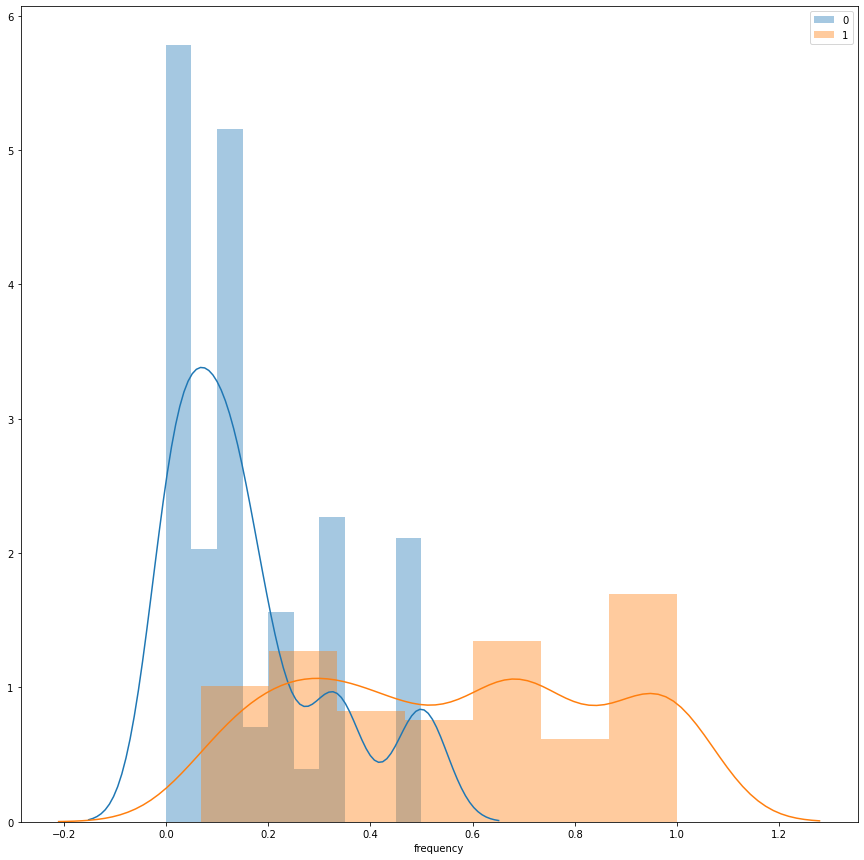

In [55]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))

for name, dat in d5.groupby('reordered'):
    sns.distplot(dat.frequency, label=name, ax=ax)
ax.legend();

In [7]:
def sample_users(orders, sample_size=1000, dataset='prior'):
    user_idxs = (
        orders
        .loc[orders.eval_set == dataset]
        .user_id
        .unique() |
        p(np.random.choice, size=sample_size, replace=False)
    )
    
    cond1 = orders.user_id.isin(user_idxs)
    cond2 = orders.eval_set == dataset
    
    return (
        orders
        .loc[cond1 & cond2]
    )

def sample_products(product_orders, user_orders):
    return (
        product_orders
        .pipe(lambda df:
             df.loc[df.order_id.isin(user_orders.order_id)])
    )
    
sample_user_orders = sample_users(user_orders)
sample_prod_orders = sample_products(product_orders, sample_user_orders)

In [ ]:
def feat_users_reorder_stats(user_orders, product_orders):
    return (
        user_orders
        .merge(product_orders, left_index=True, right_on='order_id')
        .groupby('user_id')
        .agg(
            pct_reordered=('reordered', 'mean'),
            tot_reordered=('reordered', 'sum'),
        )
    )

def feat_prods_reorder_stats(product_orders):
    return (
        product_orders
        .groupby('product_id')
        .agg(
            pct_reordered=('reordered', 'mean'),
            tot_reordered=('reordered', 'sum'),
        )
    )

def feat_target_variable(user_orders, prod_orders):
    return pd.merge(
        prod_orders,
        user_orders,
        left_on='order_id',
        right_on='order_id',
    ).loc[:, ['order_id', 'product_id', 'user_id', 'reordered']]


def merge_features(user_features, product_features, user_orders, product_orders):
    return (
        product_orders
        .merge(user_orders, left_on='order_id', right_on='order_id')
        .merge(user_features, left_on='user_id', right_on='user_id')
        .merge(product_features, left_on='product_id', right_on='product_id')
    )


In [130]:
sample_prod_orders.order_id.nunique()

15837

In [ ]:
product_orders.pipe(lambda df: df.loc[df.order_id.isin(user_orders.order_id)])

In [131]:
sample_user_orders.order_id.nunique()

15837

In [103]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,pct_reordered,tot_reordered,product_id,add_to_cart_order,reordered
0,2817237,141,prior,1,0,15,NaN,0.146341,6,13176,1,0
1,2817237,141,prior,1,0,15,NaN,0.146341,6,44632,2,0
2,2817237,141,prior,1,0,15,NaN,0.146341,6,41149,3,0
3,2817237,141,prior,1,0,15,NaN,0.146341,6,9387,4,0
4,2817237,141,prior,1,0,15,NaN,0.146341,6,47766,5,0


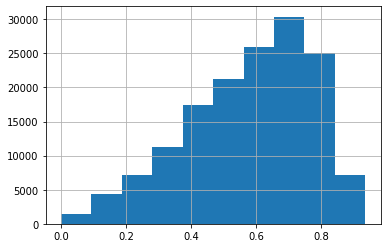

In [104]:
df.pct_reordered.hist()

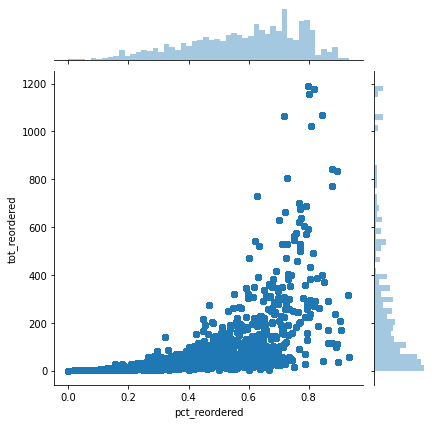

In [110]:
sns.jointplot(x='pct_reordered', y='tot_reordered', data=df)